<a href="https://colab.research.google.com/github/gulnuravci/spongebob_character_identifier/blob/main/efficientnet_b2_vs_vit_b16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
# Need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [43]:
import matplotlib.pyplot as plt
import torch
import torchvision
import pandas as pd

from pathlib import Path
from torch import nn
from torchvision import transforms
from timeit import default_timer as timer
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

try:
  import torchmetrics
except:
  !pip install -q torchmetrics
  import torchmetrics

In [3]:
# Import necessary spongebob_character_identifier files from github
try:
  import data_setup, engine, model_builder, transfer_learning_model_builder, utils, vit
except:
  !git clone https://github.com/gulnuravci/spongebob_character_identifier
  !cp spongebob_character_identifier/spongebob_character_identifier/data_setup.py .
  !cp spongebob_character_identifier/spongebob_character_identifier/engine.py .
  !cp spongebob_character_identifier/spongebob_character_identifier/model_builder.py .
  !cp spongebob_character_identifier/spongebob_character_identifier/transfer_learning_model_builder.py .
  !cp spongebob_character_identifier/spongebob_character_identifier/utils.py .
  !cp spongebob_character_identifier/spongebob_character_identifier/vit.py .
  !rm -rf spongebob_character_identifier
  import data_setup, engine, model_builder, transfer_learning_model_builder, utils, vit

Cloning into 'spongebob_character_identifier'...
remote: Enumerating objects: 1812, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (342/342), done.
remote: Total 1812 (delta 29), reused 351 (delta 20), pack-reused 1440
Receiving objects: 100% (1812/1812), 218.99 MiB | 32.95 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Updating files: 100% (1491/1491), done.


# set up device

In [4]:
device = utils.setup_target_device(device="cuda")

Current device: cuda



# get data and set up directories

In [5]:
# Import data
DATA_NAME = "character_images"
GITHUB_URL = "https://github.com/gulnuravci/spongebob_character_identifier/raw/main/character_images.zip"
data_setup.import_data_from_github(data_name=DATA_NAME, github_raw_url=GITHUB_URL)

# Setup directories
data_dir = Path("data") / DATA_NAME
train_dir = data_dir / "train"
test_dir = data_dir / "test"

data/character_images directory does not exist, importing...
Import complete.


In [6]:
import os

# Define the directory path
directory_path = "/content/models"

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Check if the directory has been created
if os.path.exists(directory_path):
    print(f"Directory '{directory_path}' has been created.")
else:
    print(f"Failed to create directory '{directory_path}'.")


Directory '/content/models' has been created.


# efficientnet_b2

## create model and get transform


In [7]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# Set the name of the model to save
MODEL_NAME = "model_efficientnet_b2"
NOTES = "Using transfer learning with PyTorch pre-trained model 'efficientnet_b2'"

# Setup hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
OUT_FEATURES = 10

# Create model
effnetb2 = transfer_learning_model_builder.create_effnetb2(out_features=OUT_FEATURES,
                                                           device=device)

# Get transform
weights = EfficientNet_B2_Weights.DEFAULT
auto_transforms = weights.transforms()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 46.2MB/s]


[INFO] Created new effnetb2 model.


In [8]:
# Summary
utils.summarize_model(model=effnetb2,
                      input_size=(32, 3, 224, 224),
                      col_names=["input_size", "output_size", "num_params", "trainable"],
                      col_width=20,
                      row_settings=["var_names"])

## create dataloaders, loss, and optimizer

In [9]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=auto_transforms,
                                                                               test_transform=auto_transforms,
                                                                               batch_size=BATCH_SIZE,
                                                                               device=device)

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2.parameters(),
                             lr=LEARNING_RATE)

## train

In [11]:
# set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [12]:
# Start the timer
start_time = timer()

# Setup training and save the results
effnetb2_results = engine.train(model=effnetb2,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS,
                             device=device,
                             writer=utils.create_writer(experiment_name="original",
                                                 model_name=MODEL_NAME,
                                                 extra=f"{NUM_EPOCHS}_epochs"))

# End the timer and print out how long it took
end_time = timer()
effnetb2_total_time = end_time-start_time

[INFO] Created SummaryWriter, saving to: runs/2023-11-12/original/model_efficientnet_b2/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8021 | train_acc: 0.6000 | test_loss: 1.2405 | test_acc: 0.9180
Epoch: 2 | train_loss: 0.9682 | train_acc: 0.9490 | test_loss: 0.7328 | test_acc: 0.9609
Epoch: 3 | train_loss: 0.6229 | train_acc: 0.9563 | test_loss: 0.5023 | test_acc: 0.9648
Epoch: 4 | train_loss: 0.4406 | train_acc: 0.9771 | test_loss: 0.3830 | test_acc: 0.9609
Epoch: 5 | train_loss: 0.3598 | train_acc: 0.9802 | test_loss: 0.3146 | test_acc: 0.9648
Epoch: 6 | train_loss: 0.2915 | train_acc: 0.9812 | test_loss: 0.2752 | test_acc: 0.9648
Epoch: 7 | train_loss: 0.2410 | train_acc: 0.9823 | test_loss: 0.2453 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.2179 | train_acc: 0.9823 | test_loss: 0.2248 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.1846 | train_acc: 0.9854 | test_loss: 0.2063 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.1632 | train_acc: 0.9927 | test_loss: 0.1962 | test_acc: 0.9648


## save model

In [13]:
# Save the model
utils.save_model_with_hyperparameters(model=effnetb2,
                                      model_results=effnetb2_results,
                                      target_dir="models",
                                      model_name=MODEL_NAME,
                                      num_epochs=NUM_EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      hidden_units="N/A",
                                      learning_rate=LEARNING_RATE,
                                      image_size="224x224",
                                      train_dataloader_length=len(train_dataloader),
                                      test_dataloader_length=len(test_dataloader),
                                      notes=NOTES)

## plot loss curves and confusion matrix

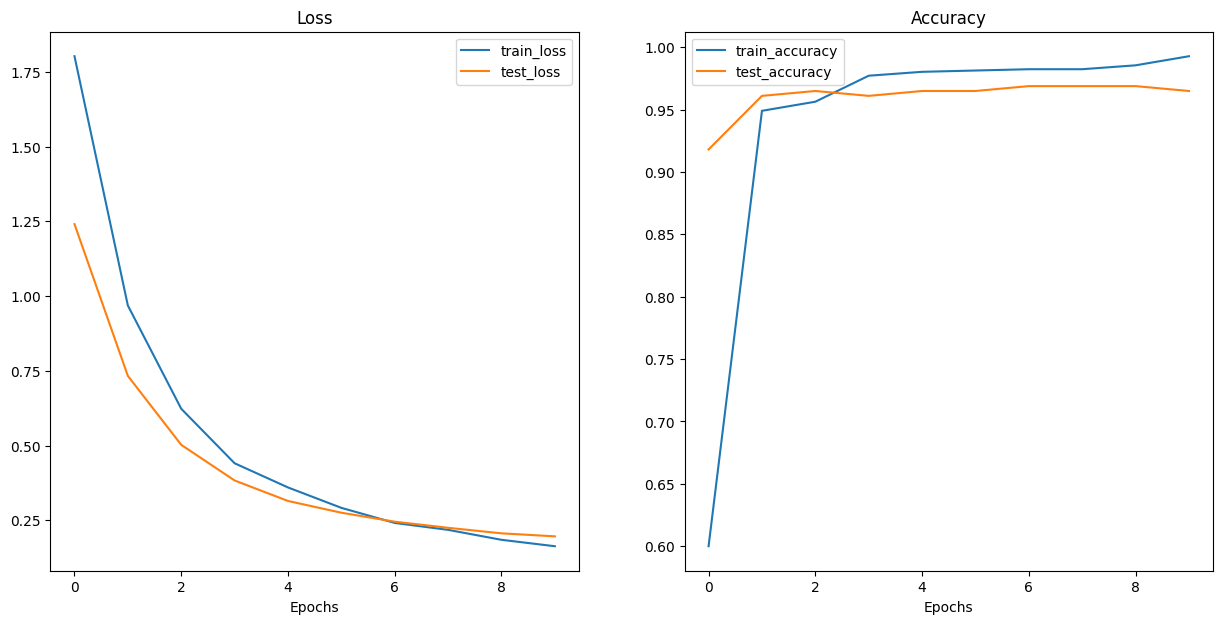

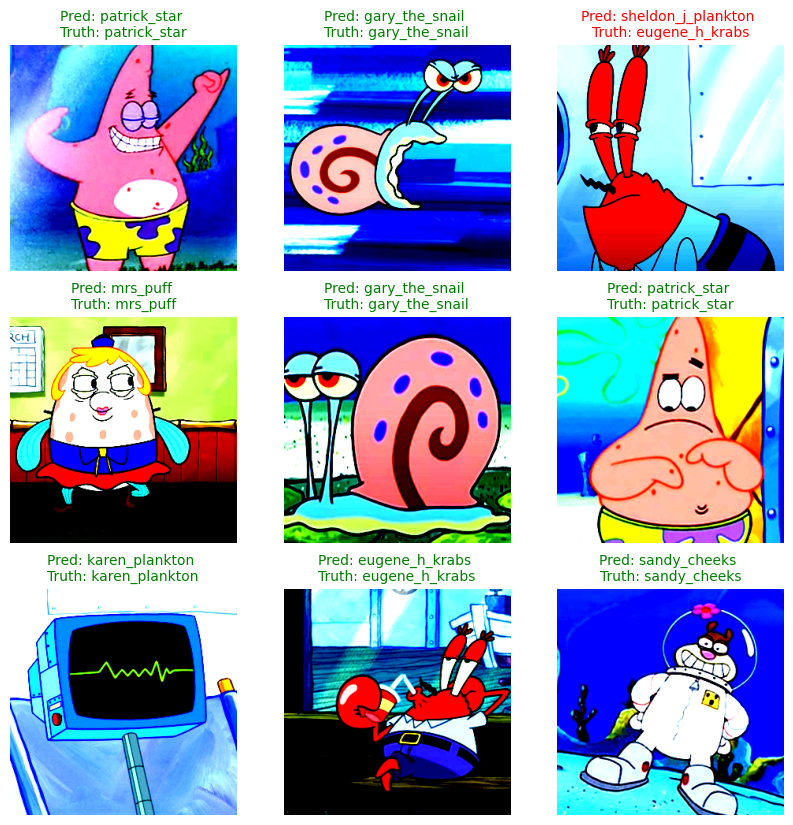

Making predictions...:   0%|          | 0/8 [00:00<?, ?it/s]

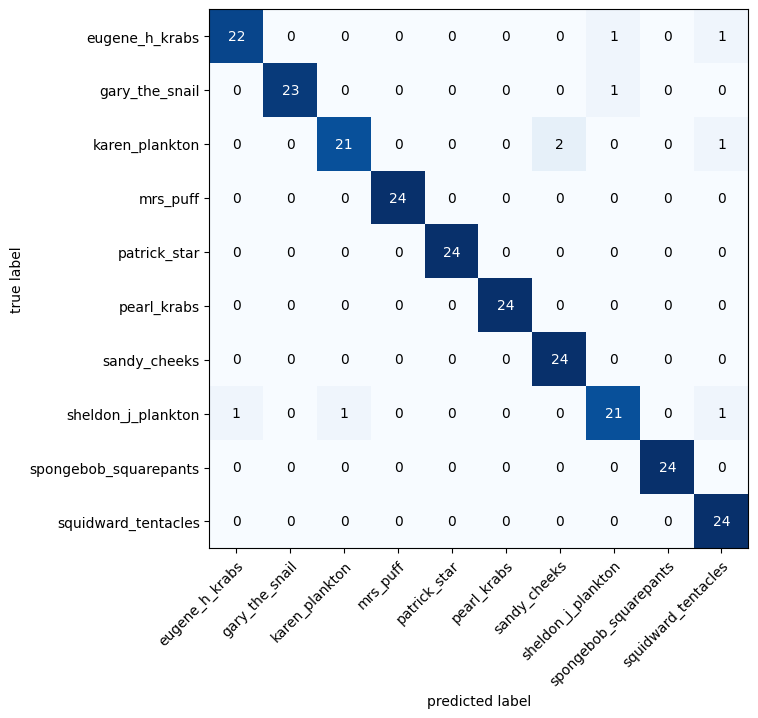

In [14]:
# Plot loss curves
utils.plot_loss_curves(results=effnetb2_results)

# Plot predictions
utils.plot_predictions(model=effnetb2,
                       test_dir=test_dir,
                       data_transform=auto_transforms)

# Plot confusion matrix
utils.confusion_matrix(model=effnetb2,
                       test_dataloader=test_dataloader,
                       test_dir = test_dir,
                       test_transform=auto_transforms,
                       device="cpu")

## get results info

In [15]:
# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(f"models/{MODEL_NAME}.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [16]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7715084

In [17]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": effnetb2_model_size,
                  "training_time": effnetb2_total_time}
effnetb2_stats

{'test_loss': 0.19622494373470545,
 'test_acc': 0.96484375,
 'number_of_parameters': 7715084,
 'model_size (MB)': 29,
 'training_time': 349.728808713}

# ViT

## create model and get transform

In [18]:
# Set the name of the model to save
MODEL_NAME = "pre_trained_ViT"
NOTES = "N/A"

# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper

# Get pretrainted weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Change the classifier head
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 173MB/s]


In [19]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## create dataloaders, loss, and optimizer

In [20]:
# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms,
    test_transform=manual_transforms,
    batch_size=BATCH_SIZE,
    device=device
)

In [21]:
# Setup the optimizer to optimize the ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()


## train

In [22]:
# set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [23]:
# Start the timer
start_time = timer()

# Train the model
vit_results = engine.train(model=pretrained_vit,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=10,
                             device=device,
                             writer=utils.create_writer(experiment_name="original",
                                                 model_name=MODEL_NAME,
                                                 extra=f"{10}_epochs"))

# End the timer and print out how long it took
end_time = timer()
vit_total_time = end_time-start_time

[INFO] Created SummaryWriter, saving to: runs/2023-11-12/original/pre_trained_ViT/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6894 | train_acc: 0.5198 | test_loss: 1.1065 | test_acc: 0.8086
Epoch: 2 | train_loss: 0.8251 | train_acc: 0.9094 | test_loss: 0.6690 | test_acc: 0.9180
Epoch: 3 | train_loss: 0.5243 | train_acc: 0.9510 | test_loss: 0.5045 | test_acc: 0.9258
Epoch: 4 | train_loss: 0.3777 | train_acc: 0.9635 | test_loss: 0.4103 | test_acc: 0.9336
Epoch: 5 | train_loss: 0.2897 | train_acc: 0.9812 | test_loss: 0.3567 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.2319 | train_acc: 0.9865 | test_loss: 0.3130 | test_acc: 0.9414
Epoch: 7 | train_loss: 0.1889 | train_acc: 0.9917 | test_loss: 0.2854 | test_acc: 0.9414
Epoch: 8 | train_loss: 0.1593 | train_acc: 0.9958 | test_loss: 0.2667 | test_acc: 0.9414
Epoch: 9 | train_loss: 0.1362 | train_acc: 0.9979 | test_loss: 0.2454 | test_acc: 0.9414
Epoch: 10 | train_loss: 0.1174 | train_acc: 0.9979 | test_loss: 0.2337 | test_acc: 0.9453


## save model

In [24]:
# Save the model
utils.save_model_with_hyperparameters(model=pretrained_vit,
                                      model_results=vit_results,
                                      target_dir="models",
                                      model_name=MODEL_NAME,
                                      num_epochs=10,
                                      batch_size=BATCH_SIZE,
                                      hidden_units="N/A",
                                      learning_rate="1e-3",
                                      image_size="224x224",
                                      train_dataloader_length=len(train_dataloader),
                                      test_dataloader_length=len(test_dataloader),
                                      notes=f"Training time:{end_time-start_time}")

## plot loss curves and confusion matrix

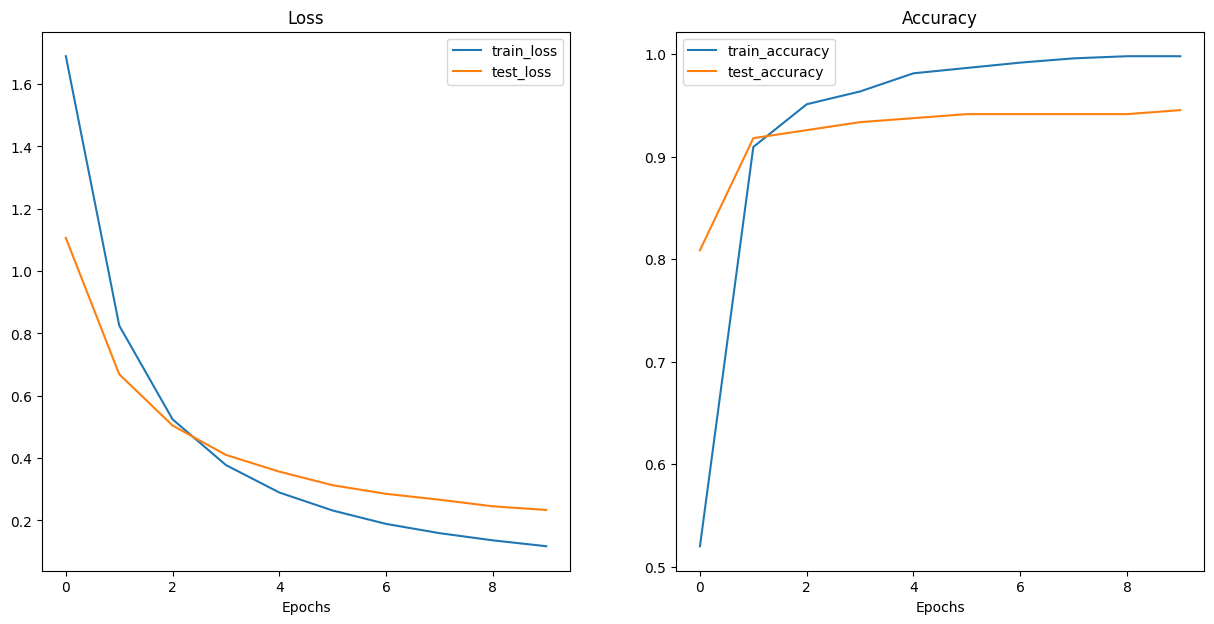

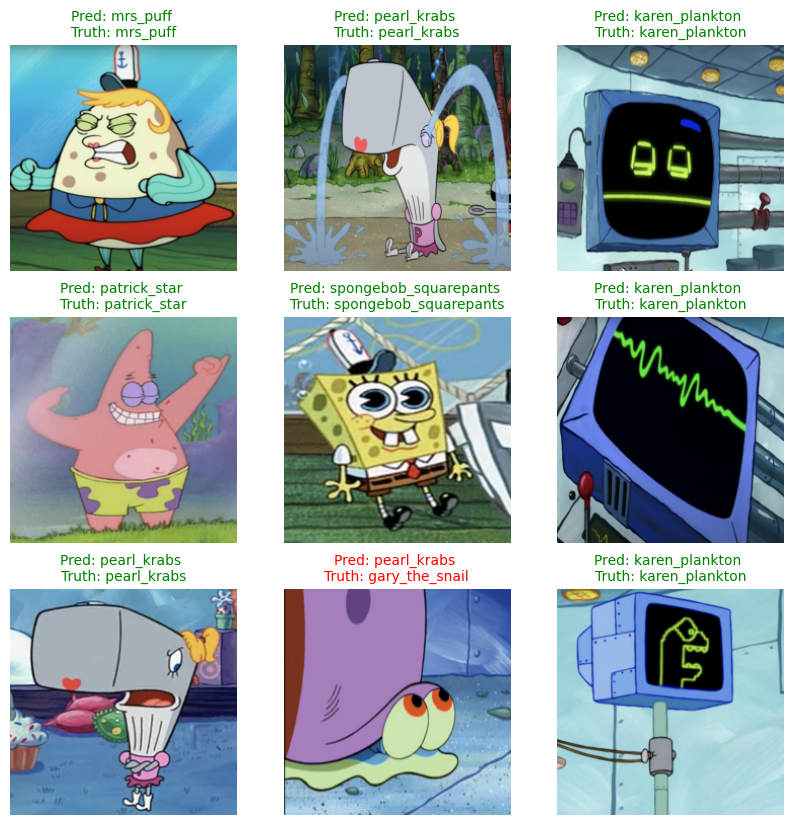

Making predictions...:   0%|          | 0/8 [00:00<?, ?it/s]

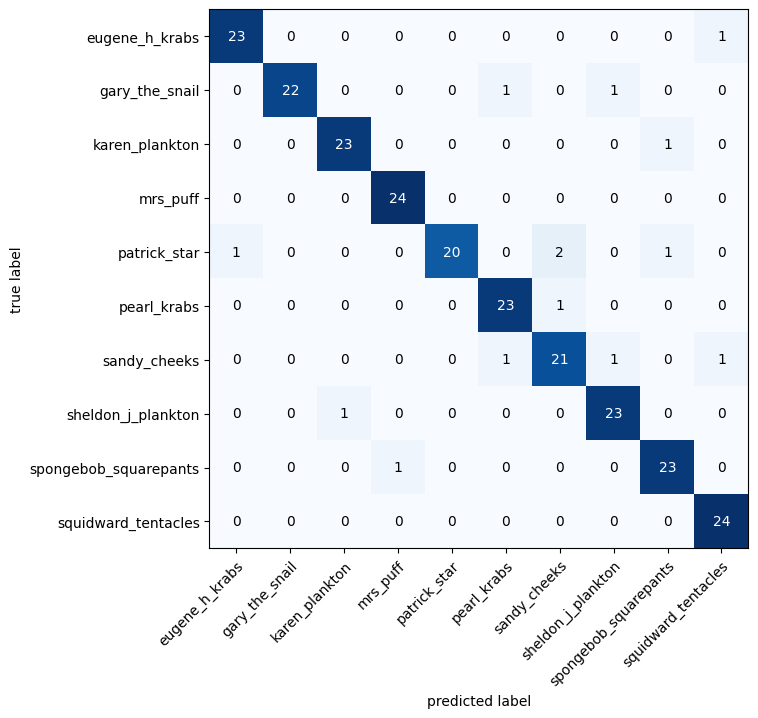

In [25]:
# Plot loss curves
utils.plot_loss_curves(results=vit_results)

# Plot predictions
utils.plot_predictions(model=pretrained_vit,
                       test_dir=test_dir,
                       data_transform=manual_transforms)

# Plot confusion matrix
utils.confusion_matrix(model=pretrained_vit,
                       test_dataloader=test_dataloader,
                       test_dir = test_dir,
                       test_transform=manual_transforms,
                       device="cpu")


## get results info

In [26]:
# Get the model size in bytes then convert to megabytes
vit_model_size = Path(f"models/{MODEL_NAME}.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [27]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in pretrained_vit.parameters())
vit_total_params

85806346

In [28]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": vit_model_size,
             "training_time": vit_total_time}

vit_stats

{'test_loss': 0.2336904415860772,
 'test_acc': 0.9453125,
 'number_of_parameters': 85806346,
 'model_size (MB)': 327,
 'training_time': 329.526577213}

# time predictions

In [29]:
# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5], len(test_data_paths)

[INFO] Finding all filepaths ending with '.jpg' in directory: data/character_images/test


([PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_64.jpg'),
  PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_85.jpg'),
  PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_90.jpg'),
  PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_54.jpg'),
  PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_21.jpg')],
 240)

In [38]:
def pred_and_store(paths: List[Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str="cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # Create an empty list to store prediction dictionaires
  pred_list = []

  # Loop through target paths
  for path in tqdm(paths):
    # Create empty dictionary to store prediction information for each sample
    pred_dict = {}

    # Get the sample path and ground truth class name
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Start the prediction timer
    start_time = timer()

    # Open image path
    img = Image.open(path)

    # Transform the image, add batch dimension, and put image on target device
    transformed_image = transform(img).unsqueeze(dim=0).to(device)

    # Prepare model for inference by sending it to target device and turning on eval() mode
    model.to(device)
    model.eval()

    # Get prediction probability, prediction label, and prediction class
    with torch.inference_mode():
      pred_logit = model(transformed_image) # perform inference on target sample
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
      pred_class = class_names[pred_label.cpu()] # make sure class to be on cpu

      # Make sure things in the dictionary are on CPU
      pred_dict["pred_prob"] = round(pred_prob.max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # End the timer and calculate time per pred
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # Add the dictionary to the list of preds
    pred_list.append(pred_dict)

  # Return list of prediction dictionaries
  return pred_list

## make effnetb2 test predictions

In [39]:
# Make predictions across test dataset with effnet_b2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=auto_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/240 [00:00<?, ?it/s]

In [41]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:5]

[{'image_path': PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_64.jpg'),
  'class_name': 'eugene_h_krabs',
  'pred_prob': 0.4147,
  'pred_class': 'eugene_h_krabs',
  'time_for_pred': 0.1494,
  'correct': True},
 {'image_path': PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_85.jpg'),
  'class_name': 'eugene_h_krabs',
  'pred_prob': 0.7069,
  'pred_class': 'eugene_h_krabs',
  'time_for_pred': 0.1255,
  'correct': True},
 {'image_path': PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_90.jpg'),
  'class_name': 'eugene_h_krabs',
  'pred_prob': 0.6857,
  'pred_class': 'eugene_h_krabs',
  'time_for_pred': 0.1303,
  'correct': True},
 {'image_path': PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_54.jpg'),
  'class_name': 'eugene_h_krabs',
  'pred_prob': 0.9444,
  'pred_class': 'eugene_h_krabs',
  'time_for_pred': 0.135,
  'correct': True},
 {'image_path': PosixPath('data/character_images/test/eugene_h_krabs/euge

In [44]:
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/character_images/test/eugene_h_krabs/euge...,eugene_h_krabs,0.4147,eugene_h_krabs,0.1494,True
1,data/character_images/test/eugene_h_krabs/euge...,eugene_h_krabs,0.7069,eugene_h_krabs,0.1255,True
2,data/character_images/test/eugene_h_krabs/euge...,eugene_h_krabs,0.6857,eugene_h_krabs,0.1303,True
3,data/character_images/test/eugene_h_krabs/euge...,eugene_h_krabs,0.9444,eugene_h_krabs,0.1350,True
4,data/character_images/test/eugene_h_krabs/euge...,eugene_h_krabs,0.9214,eugene_h_krabs,0.1110,True


In [45]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     231
False      9
Name: correct, dtype: int64

In [46]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1437 seconds


In [47]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.19622494373470545,
 'test_acc': 0.96484375,
 'number_of_parameters': 7715084,
 'model_size (MB)': 29,
 'training_time': 349.728808713,
 'time_per_pred_cpu': 0.1437}

## make vit test predictions

In [50]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=pretrained_vit,
                                     transform=manual_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/240 [00:00<?, ?it/s]

In [51]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:5]

[{'image_path': PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_64.jpg'),
  'class_name': 'eugene_h_krabs',
  'pred_prob': 0.7616,
  'pred_class': 'eugene_h_krabs',
  'time_for_pred': 0.6247,
  'correct': True},
 {'image_path': PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_85.jpg'),
  'class_name': 'eugene_h_krabs',
  'pred_prob': 0.9088,
  'pred_class': 'eugene_h_krabs',
  'time_for_pred': 0.5951,
  'correct': True},
 {'image_path': PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_90.jpg'),
  'class_name': 'eugene_h_krabs',
  'pred_prob': 0.3268,
  'pred_class': 'eugene_h_krabs',
  'time_for_pred': 0.5822,
  'correct': True},
 {'image_path': PosixPath('data/character_images/test/eugene_h_krabs/eugene_h_krabs_54.jpg'),
  'class_name': 'eugene_h_krabs',
  'pred_prob': 0.9613,
  'pred_class': 'eugene_h_krabs',
  'time_for_pred': 0.6068,
  'correct': True},
 {'image_path': PosixPath('data/character_images/test/eugene_h_krabs/eug

In [52]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/character_images/test/eugene_h_krabs/euge...,eugene_h_krabs,0.7616,eugene_h_krabs,0.6247,True
1,data/character_images/test/eugene_h_krabs/euge...,eugene_h_krabs,0.9088,eugene_h_krabs,0.5951,True
2,data/character_images/test/eugene_h_krabs/euge...,eugene_h_krabs,0.3268,eugene_h_krabs,0.5822,True
3,data/character_images/test/eugene_h_krabs/euge...,eugene_h_krabs,0.9613,eugene_h_krabs,0.6068,True
4,data/character_images/test/eugene_h_krabs/euge...,eugene_h_krabs,0.9767,eugene_h_krabs,0.5844,True


In [53]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     226
False     14
Name: correct, dtype: int64

In [54]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.6619 seconds


In [55]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.2336904415860772,
 'test_acc': 0.9453125,
 'number_of_parameters': 85806346,
 'model_size (MB)': 327,
 'training_time': 329.526577213,
 'time_per_pred_cpu': 0.6619}

# compare model results, prediction times and size

In [56]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),training_time,time_per_pred_cpu,model
0,0.196225,96.48,7715084,29,349.728809,0.1437,EffNetB2
1,0.233690,94.53,85806346,327,329.526577,0.6619,ViT


In [57]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),training_time,time_per_pred_cpu
ViT to EffNetB2 ratios,1.190931,0.979789,11.121894,11.275862,0.942235,4.606124


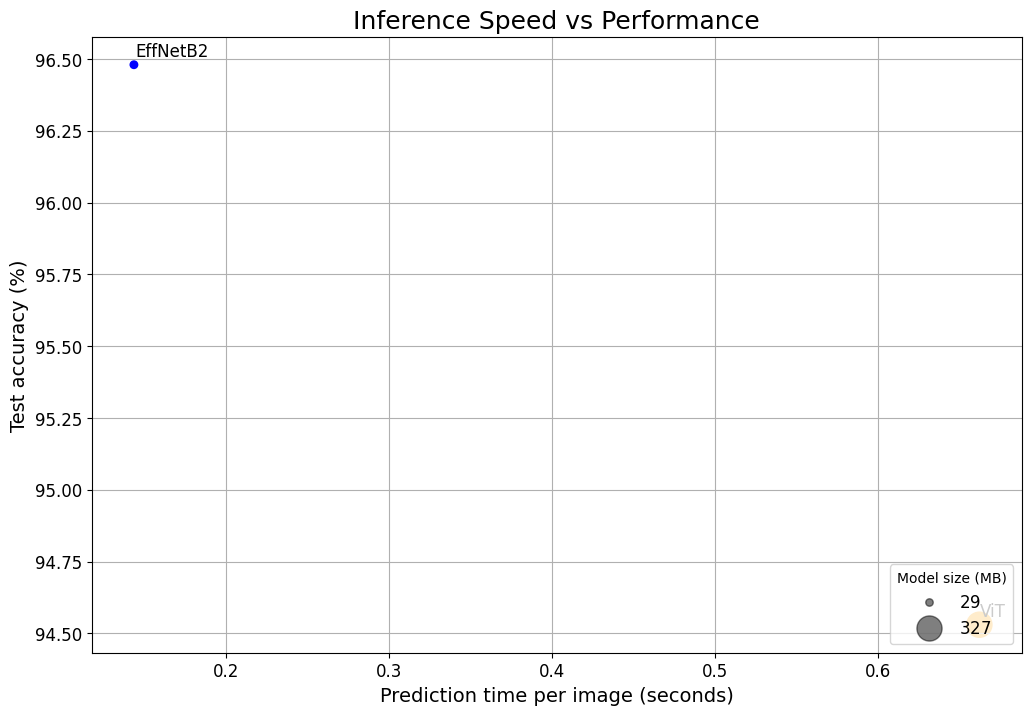

In [60]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("inference-speed-vs-performance.jpg")

# Show the figure
plt.show()